## Install Package

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00


In [ ]:
import collections
import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import transformers
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Dataset

In [ ]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
# Load the dataset
dataset = datasets.load_dataset("ugursa/Yahoo-Finance-News-Sentences")

# Split the dataset into training and testing sets
train_data, test_data = dataset["train"].train_test_split(test_size=0.2).values()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

## Import Pre-trained BERT

In [ ]:
transformer_name = "bert-base-uncased"

tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def tokenize_and_numericalize_example(example, tokenizer):
    ids = tokenizer(example["text"], truncation=True)["input_ids"]
    return {"ids": ids}

In [ ]:
train_data = train_data.map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)
test_data = test_data.map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)

Map:   0%|          | 0/20025 [00:00<?, ? examples/s]

Map:   0%|          | 0/5007 [00:00<?, ? examples/s]

In [ ]:
pad_index = tokenizer.pad_token_id

In [ ]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [ ]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [ ]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

In [ ]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [ ]:
batch_size = 8

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

## Define Transformer

In [ ]:
class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, ids):
        # ids = [batch size, seq len]
        output = self.transformer(ids, output_attentions=True)
        hidden = output.last_hidden_state
        # hidden = [batch size, seq len, hidden dim]
        attention = output.attentions[-1]
        # attention = [batch size, n heads, seq len, seq len]
        cls_hidden = hidden[:, 0, :]
        prediction = self.fc(torch.tanh(cls_hidden))
        # prediction = [batch size, output dim]
        return prediction

In [ ]:
transformer = transformers.AutoModel.from_pretrained(transformer_name)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
output_dim = len(train_data["label"].unique())
freeze = False

model = Transformer(transformer, output_dim, freeze)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 109,484,547 trainable parameters


In [ ]:
lr = 1e-6

# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [ ]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [ ]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

## Training and Validation

In [ ]:
import torch
import collections

# Check if GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_epochs = 10
best_valid_loss = float("inf")

# Move your model to the selected device
model = model.to(device)

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(
        valid_data_loader, model, criterion, device
    )

    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        model_save_path = '/content/drive/MyDrive/UofT/grad/ece1508/Final_Project/sentiment_analysis/BERT_Model/transformer.pt'
        # Ensure the model saved is in CPU format for compatibility
        torch.save(model.to('cpu').state_dict(), model_save_path)
        # Move model back to GPU if necessary
        model.to(device)

    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")


evaluating...: 100%|██████████| 626/626 [00:21<00:00, 29.30it/s]


epoch: 0
train_loss: 0.683, train_acc: 0.704
valid_loss: 0.376, valid_acc: 0.857


evaluating...: 100%|██████████| 626/626 [00:21<00:00, 28.94it/s]


epoch: 1
train_loss: 0.326, train_acc: 0.878
valid_loss: 0.285, valid_acc: 0.894


evaluating...: 100%|██████████| 626/626 [00:21<00:00, 28.76it/s]


epoch: 2
train_loss: 0.251, train_acc: 0.907
valid_loss: 0.249, valid_acc: 0.912


evaluating...: 100%|██████████| 626/626 [00:21<00:00, 28.90it/s]


epoch: 3
train_loss: 0.205, train_acc: 0.925
valid_loss: 0.238, valid_acc: 0.913


evaluating...: 100%|██████████| 626/626 [00:21<00:00, 28.93it/s]


epoch: 4
train_loss: 0.167, train_acc: 0.939
valid_loss: 0.234, valid_acc: 0.917


evaluating...: 100%|██████████| 626/626 [00:21<00:00, 29.09it/s]


epoch: 5
train_loss: 0.141, train_acc: 0.950
valid_loss: 0.247, valid_acc: 0.916


evaluating...: 100%|██████████| 626/626 [00:21<00:00, 29.00it/s]


epoch: 6
train_loss: 0.120, train_acc: 0.958
valid_loss: 0.241, valid_acc: 0.917


evaluating...: 100%|██████████| 626/626 [00:21<00:00, 28.98it/s]


epoch: 7
train_loss: 0.097, train_acc: 0.966
valid_loss: 0.253, valid_acc: 0.920


evaluating...: 100%|██████████| 626/626 [00:21<00:00, 28.96it/s]


epoch: 8
train_loss: 0.083, train_acc: 0.973
valid_loss: 0.252, valid_acc: 0.922


evaluating...: 100%|██████████| 626/626 [00:21<00:00, 28.92it/s]

epoch: 9
train_loss: 0.067, train_acc: 0.978
valid_loss: 0.278, valid_acc: 0.918


In [ ]:
metrics["train_losses"]

[0.6828622120979051,
 0.32621057154422306,
 0.2511088114640456,
 0.20501754152974366,
 0.16713756192435886,
 0.14112804453627575,
 0.12002829936927104,
 0.09716655696961429,
 0.08251167750721242,
 0.06739157049173312]

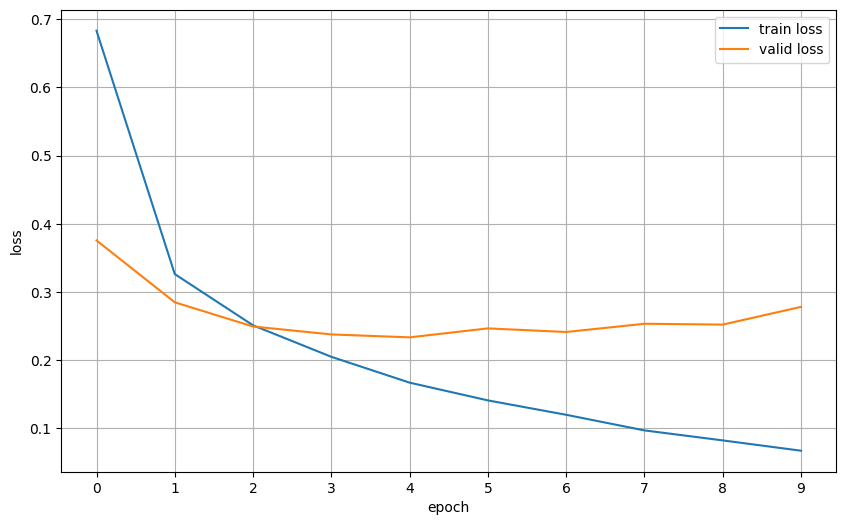

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

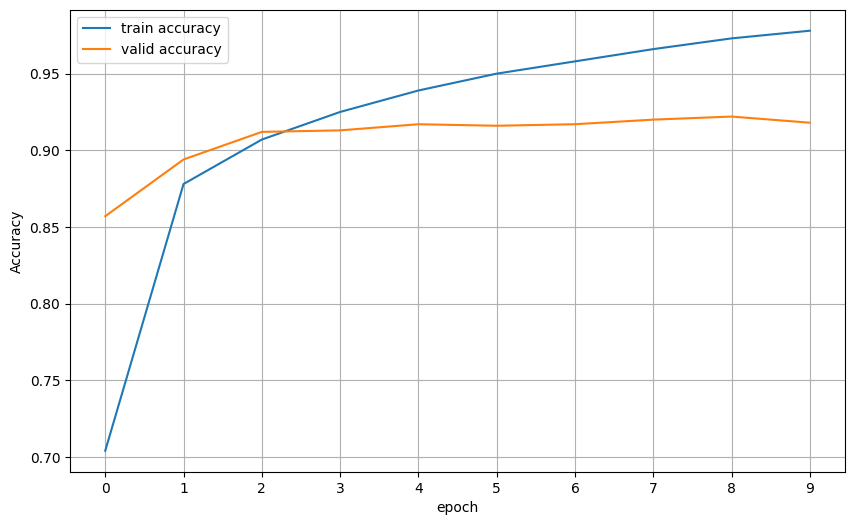

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss") # This should be accuracy
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

## Load Trained Transformer

In [ ]:
model_save_path = '/content/drive/MyDrive/UofT/grad/ece1508/Final_Project/sentiment_analysis/BERT_Model/transformer.pt'

model.load_state_dict(torch.load(model_save_path))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|██████████| 626/626 [00:19<00:00, 32.25it/s]


In [ ]:
test_acc

0.9195287539936102

In [ ]:
def predict_sentiment(text, model, tokenizer, device):
    ids = tokenizer(text)["input_ids"]
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

0 positive, 1 neutral, 2 is negative,

In [ ]:
text='As most techology stocks reel from higher interest rates and slowing growth, one top-performing hedge fund manager is going against the tide to bet on the sinking shares of Facebook-owner Meta Platforms. Expensive Silicon Valley tech wouldn’t normally feature on the shopping list for the Liontrust GF Tortoise Fund, which its manager Tom Morris describes as a “value-focused hedge fund,” seeking out shares it deems to be cheap“We are value managers but parts of tech are actually value stocks now,” said Morris, who co-manages the $600 million fund with Matthew SmithTortoise has outperformed 99% of its long-short equity fund peers this year, with returns of about 22%, compared with the 12% decline of the  Equity Long/Short Hedge Fund IndexNow though, Morris reckons it’s time to be “sensibly contrarian”	For perspective, Meta doesn’t rank among the 25 largest holdings of the $20.4 billion iShares ESG Aware MSCI USA ETF. Separately, Meta Platforms was slapped with a €265 million ($277 million) fine for failing to prevent the leak of personal data for more than half a billion users of its Facebook service'
predict_sentiment(text, model, tokenizer, device)

(2, 0.9822255373001099)

In [ ]:
import pandas as pd
path='/content/drive/MyDrive/UofT/grad/ece1508/Final_Project/sentiment_analysis/'
news_data=pd.read_csv(path + "/"+"NYT_news_2003-2023_hedge.csv")
news_data=news_data.dropna()
news_data=news_data.iloc[:,1:]

In [ ]:
news_data

,Date,Text
0,2003-04-08,"Leon Levy, a hedge fund pioneer who began inve..."
1,2003-04-15,"HEWLETT-PACKARD CO., Palo Alto, Calif., won a ..."
2,2003-04-24,Officials in the enforcement division of the S...
3,2003-04-27,Alexandra Elizabeth Conway and Steven Andrew M...
4,2003-05-04,"UNTIL last month, Michael A. McManus Jr., the ..."
...,...,...
7376,2023-10-26,As the Showtime financial thriller “Billions” ...
7377,2023-11-06,"Two Sigma, one of the world’s largest hedge fu..."
7378,2023-11-06,Ray Dalio is the titan behind the world’s bigg...
7379,2023-11-25,The U.S. Open has long catered to tennis fans ...


Need to solve the Tensor sizes problem, make the data more clean

In [ ]:
list_sentiment=[]
list_prob=[]
for index, row in tqdm.tqdm(news_data.iterrows(), total=len(news_data)):
  words = row['Text'].split()
  word_count = len(words)
  if word_count > 200:
    # Take the first 200 words
    first_500_words = words[:200]

    # Join the words back into a string
    shortened_string = ' '.join(first_500_words)
    res_sent,res_prob=predict_sentiment(shortened_string, model, tokenizer, device)
  else:
    res_sent,res_prob=predict_sentiment(row['Text'], model, tokenizer, device)

  list_sentiment.append(res_sent)
  list_prob.append(res_prob)

100%|██████████| 7376/7376 [01:58<00:00, 62.13it/s]


In [ ]:
news_data['Sentiment']=list_sentiment
news_data['Probability']=list_prob

In [ ]:
replacement_map = {0: 1, 1: 0, 2: -1}
news_data['Sentiment'] = news_data['Sentiment'].replace(replacement_map)

In [ ]:
news_data

,Date,Text,Sentiment,Probability
0,2003-04-08,"Leon Levy, a hedge fund pioneer who began inve...",0,0.955218
1,2003-04-15,"HEWLETT-PACKARD CO., Palo Alto, Calif., won a ...",1,0.851181
2,2003-04-24,Officials in the enforcement division of the S...,0,0.989978
3,2003-04-27,Alexandra Elizabeth Conway and Steven Andrew M...,0,0.955451
4,2003-05-04,"UNTIL last month, Michael A. McManus Jr., the ...",1,0.993122
...,...,...,...,...
7376,2023-10-26,As the Showtime financial thriller “Billions” ...,0,0.984241
7377,2023-11-06,"Two Sigma, one of the world’s largest hedge fu...",0,0.831409
7378,2023-11-06,Ray Dalio is the titan behind the world’s bigg...,0,0.975477
7379,2023-11-25,The U.S. Open has long catered to tennis fans ...,0,0.738680


In [ ]:
news_data.to_csv(path+"/"+"add_sentiment_news_nyt_hedge.csv")

In [ ]:
news_data_complete=pd.read_csv(path+"/"+"add_sentiment_news.csv")

In [ ]:
news_data=news_data_complete.iloc[353:,:]

In [ ]:
news_data['Date'] = pd.to_datetime(news_data['Date'])

# Create a year-month column
news_data['year-month'] = news_data['Date'].dt.strftime('%Y-%m')

# Group by the year-month column and sum the Sentiment column
result = news_data.groupby('year-month')['Sentiment'].mean().reset_index()
